In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import pylab as pp
import numpy as np
import scipy as sp

import os
import datetime

# Import curve fitting package from scipy
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score,mean_squared_error

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# imports required by WindowGenerator_RUL.timeseries_dataset_from_array method
from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.util.tf_export import keras_export


# loading the formated datasets

In [3]:
trainData = []
testData = []
RUL = []

for i in range(1,5):
    trainData.append( pd.read_csv(('train_FD00%d_smooth.csv' % i),
                                  sep=' ',
                                  index_col=(0,1),
                                  header = 0,
                                  decimal='.',
                                  engine='python'))
    testData.append(pd.read_table(('test_FD00%d_smooth.csv' % i),
                                  sep=' ',
                                  index_col=(0,1),
                                  header = 0,
                                  decimal='.',
                                  engine='python'))
    RUL.append(pd.read_table(('RUL_FD00%d.txt' % i),
                             sep=' ',
                             index_col=False,
                             names=['RULtime'],
                             header = None,
                             engine='python'))

#  metadata from file readme.txt
FD001 = {"Data Set Name": "FD001",
         "idx" : 0,
         "Train trjectories:": 100,
         "Test trajectories:" : 100,
         "Conditions": 1,
         "Conditions name" : "Sea Level",
         "Fault Modes": 1,
         "Fault Modes name": "HPC Degradation"}

FD002 = {"Data Set Name": "FD002",
         "idx" : 1,
         "Train trjectories:": 260,
         "Test trajectories:" : 259,
         "Conditions": 6,
         "Conditions name" : "",
         "Fault Modes": 1,
         "Fault Modes name": "HPC Degradation"}

FD003 = {"Data Set Name": "FD003",
         "idx" : 2,
         "Train trjectories:": 100,
         "Test trajectories:" : 100,
         "Conditions": 1,
         "Conditions name" : "Sea Level",
         "Fault Modes": 2,
         "Fault Modes name": ["HPC Degradation", "Fan Degradation"]}

FD004 = {"Data Set Name": "FD004",
         "idx" : 3,
         "Train trjectories:": 249,
         "Test trajectories:" : 248,
         "Conditions": 6,
         "Conditions name" : "",
         "Fault Modes": 2,
         "Fault Modes name": ["HPC Degradation", "Fan Degradation"]}

metadata = [FD001,FD002,FD003,FD004]


* data are loaded in the Pandas DataFrames
* each DF contains data from the whole file
* DF has multiindex consisting of unit and time

* The datasets are organized in two separate lists, one for training datasets, second for the test datasets.
* Unlike the original datasets, each formated dataset contain a header row with names of columns in the first row.
* The time is in cycles, counting from the last cycle recorded cycle in each trajectory. I.e. in the case of train data, the time represents the remaining useful lifetime, RUL.

## a quick peak at the smoothed and formated data FD003

In [4]:
# dataset index
meta = FD003

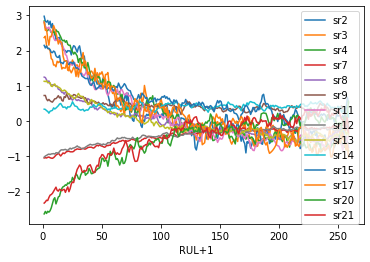

In [5]:

trainData[meta['idx']].loc[1,'sr2':].plot();

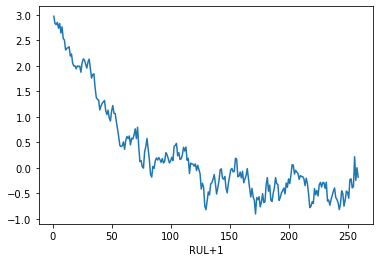

In [6]:
trainData[meta['idx']].loc[1,'sr2'].plot()

The data show typical wear curve, elbow point from where the fault develops exponentially

# data reduction with PCA

In [7]:


train_data = trainData[meta['idx']].loc[:,'sr2':] # include only the sensor readings in the PCA, not the op's

## applying the PCA on the sensor readings in whole training dataset
# Make an instance of the Model
pca = PCA(.97)
pca.fit(train_data)
print(pca.n_components_)

4


Four PCs are needed to explain more than 97% of the variance. 

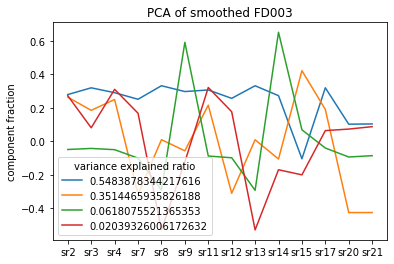

In [8]:
pp.plot(pca.components_.T,)
pp.legend(pca.explained_variance_ratio_,title='variance explained ratio');
pp.xticks(np.arange(0, len(train_data.columns), 1), train_data.columns)
pp.ylabel('component fraction');
pp.title('PCA of smoothed ' + meta['Data Set Name']) ;

The PCA characterize the two modes of fault:

* there are 4 significant PCs: listed in order of decreasing explanied variance ratio: PC1 (54%), PC2 (35 %), PC3 (6 %) and PC4 (2%)

* the green-curve PCA with about 6% expl. var. resemble the fault mode observed in the data set FD001
* unsure about the requirement for the 2% EV PC. we'll see from the transformed trajectories

In [9]:
# Apply PCA transform to both the training set and the test set.
train_data = pca.transform(train_data)
test_data = testData[meta['idx']].loc[:,'sr2':]
test_data = pca.transform(test_data)

In [10]:
print(test_data. shape, train_data.shape)

(16596, 4) (24720, 4)


### Couple the op data with the transformed sensor readings - the pcs:

In [11]:
train_dataPD = pd.DataFrame(index=trainData[meta['idx']].index,columns=['op1','op2','pc1','pc2','pc3','pc4'])
train_dataPD.loc[:,'op1':'op2'] = trainData[meta['idx']].loc[:,'op1':'op2']
train_dataPD.loc[:,'pc1':'pc4'] = train_data

test_dataPD = pd.DataFrame(index=testData[meta['idx']].index,columns=['op1','op2','pc1','pc2','pc3','pc4'])
test_dataPD.loc[:,'op1':'op2'] = testData[meta['idx']].loc[:,'op1':'op2']
test_dataPD.loc[:,'pc1':'pc4'] = test_data


In [12]:
train_dataPD.head()

op1     op2      pc1      pc2        pc3       pc4
unit RUL+1                                                       
1    1      0.0043 -0.0001  3.99856  6.66992  0.0018435  0.370615
     2     -0.0005  0.0001  3.82402  6.43589  0.0220312  0.263453
     3     -0.0032 -0.0002  3.65266  6.39414 -0.0288095  0.233016
     4      0.0019  0.0001  3.50451  6.26923 -0.0306323  0.317029
     5       0.005 -0.0004  3.46212  6.19971 -0.0543446  0.291636

In [13]:
test_dataPD.head()

op1     op2      pc1      pc2        pc3       pc4
unit time                                                       
1    1     0.0021  0.0002  3.05901 -2.57413 -0.0753175  0.264034
     2     0.0038 -0.0005  2.93333 -2.51669 -0.0487394  0.266349
     3    -0.0002  0.0004  2.89334  -2.4549  -0.103544  0.333778
     4     0.0018       0  2.84947 -2.39237  -0.122808  0.373784
     5      0.003  0.0001   2.6896 -2.28033 -0.0717677  0.381208

# look at the operational parameters

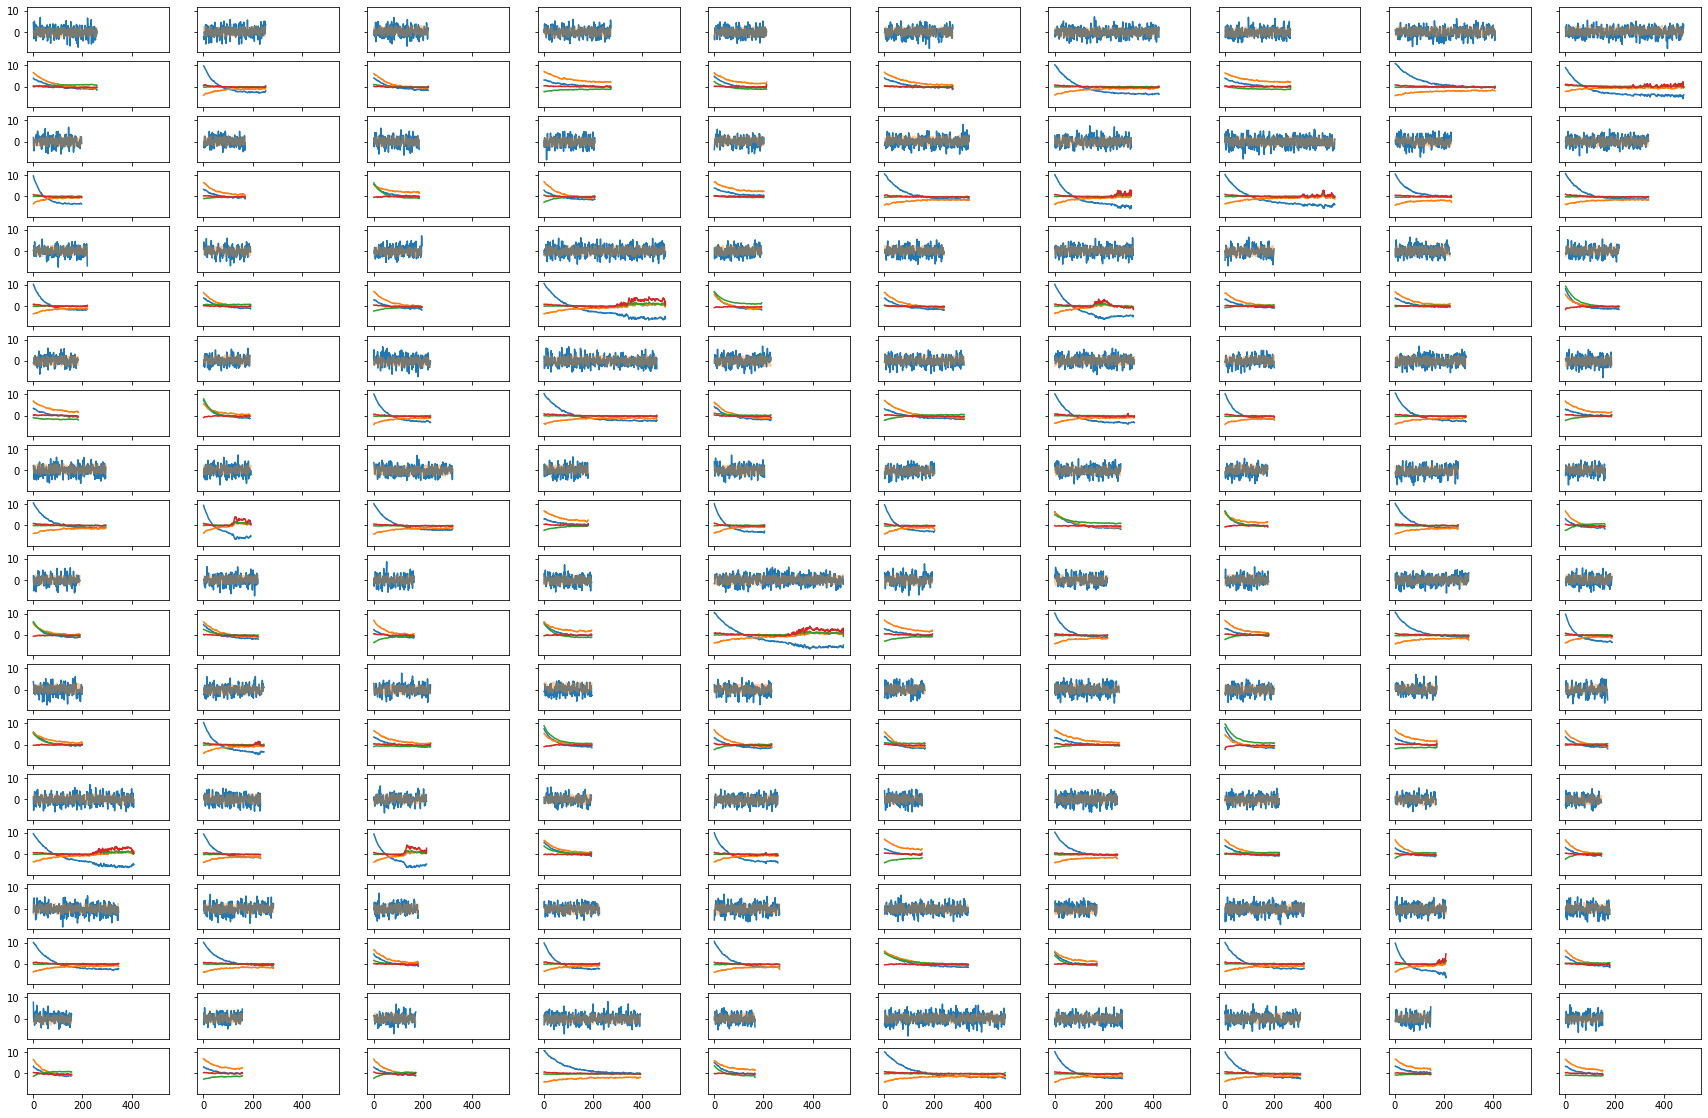

In [14]:
nrows=10
ncols=10
fig, ax = pp.subplots(figsize=(30,20),nrows=2*nrows, ncols=ncols, sharex=True, sharey=True,)
#ax=ax.flatten()
for traj_jdx in range (0,nrows,1):
    for traj_idx in range(0,ncols,1): 
        #operational parameters on every even row
        row=traj_jdx*2
        col=traj_idx
        ax[row,col].plot(train_dataPD.loc[ncols*traj_jdx+traj_idx+1,'op1']*1000)
        ax[row,col].plot(train_dataPD.loc[ncols*traj_jdx+traj_idx+1,'op2']*5000,alpha=0.4)
        # PC of the sensor readings on the every odd row
        ax[row+1,col].plot(train_dataPD.loc[ncols*traj_jdx+traj_idx+1,'pc1':'pc4'])
        #ax[traj_jdx+1,traj_idx].plot(train_dataPD.loc[traj_jdx/2+traj_idx+1,'pc2'],alpha=0.8)
        #ax[traj_jdx+1,traj_idx].plot(train_dataPD.loc[traj_jdx/2+traj_idx+1,'pc3'],alpha=0.6)
        

Observations:
* The operation conditions for all the trajectories are more-or less equal in all trajectories.
 
* some trajectories contain eviden "induction period", that is apparent from spikes (relatively high RMS noise) in PC3 ansd PC4. It indicates that the period can be oconsidered as that of a normal operation, and thus can be excluded form fault development.
* differently from the case of FD001 data set, the first PC does not always terminate at around 10, but sometimes at around 3. These are evidently the two fault modes given in the data. It is not clear, whether the combination of the two modes is possible. As that would constitute effectivelly an infinite number of combinaitons, we will not consider this in the model.
    * the first mode is characterized by first PC that terminates at value of about 10. In those cases, this PC dominates throughout the trajectory.
    * the second mode ends with second PC dominating the signals, and in those cases, this PC dominates from the onset of the exponential kinetics
* in the later case the second PC dominates, but shows the same kinetics as PC1 - exponential.

# machine learning pipeline:

* clean-up the data: remove the induction period, with high values of PC3 and PC4
* classify the trajectories in two groups dependent on the failure mode: there should be two modes
* fit the Reccurent neural network  separately per fault mode

# clustering based on PC3 and PC4 - induction period

Text(0.5, 1.0, 'trajectrory: 18')

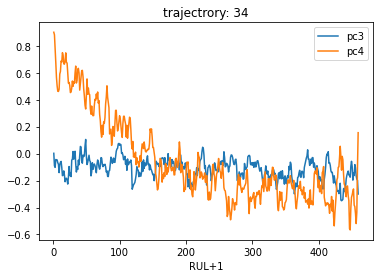

<Figure size 432x288 with 0 Axes>

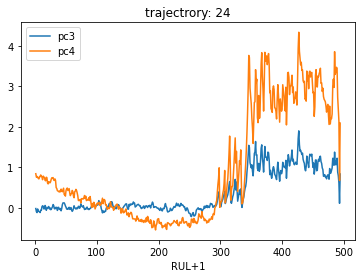

<Figure size 432x288 with 0 Axes>

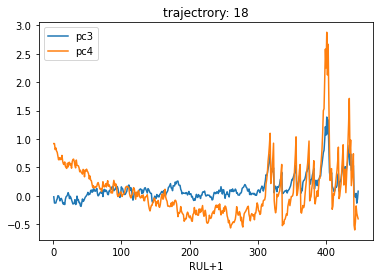

In [15]:
trajectory = 34
train_dataPD.loc[trajectory,'pc3':].plot();
pp.title('trajectrory: %d' % trajectory)

fig=pp.figure()
trajectory = 24
train_dataPD.loc[trajectory,'pc3':].plot();
pp.title('trajectrory: %d' % trajectory)

fig=pp.figure()
trajectory = 18
train_dataPD.loc[trajectory,'pc3':].plot();
pp.title('trajectrory: %d' % trajectory)

The PC4 is probably a good indicator of the system wear - its value drifts after a plateau that is slightly  below 0 to the value about 1.0, when the systems breaks down. Will try to further smoothen it and apply thresholds to dissect the trajectory into "burn-in", "normal operation", "failing"  periods. Sometimes, the burn-in period is missing.

C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


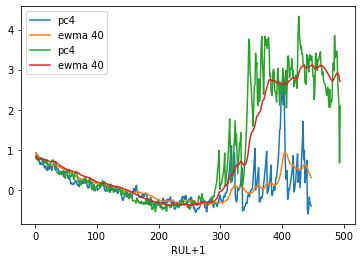

In [16]:
trajectory = 18

ax=pp.axes()
sensorTrace = train_dataPD.loc[trajectory,'pc4']
sensorTrace.plot(ax=ax)
ewma_span = 40
SM=sensorTrace.ewm(span=ewma_span,ignore_na=True).mean()
SM.plot(ax=ax,label=('ewma ' + str(ewma_span)))
SMmask=SM[SM>1]
pp.plot()

ax.legend()
trajectory = 24

ax=pp.axes()
sensorTrace = train_dataPD.loc[trajectory,'pc4']
sensorTrace.plot(ax=ax)
ewma_span = 40
sensorTrace.ewm(span=ewma_span,ignore_na=True).mean().plot(ax=ax,label=('ewma ' + str(ewma_span)))
ax.legend()

In [17]:
# what about to use moving RMS to dissect the data?

def window_rmsdev(intervalS, halfwindow):
    """ performs the moving-window smoothing of a signal using RMS """
    interval = intervalS.values
    rms_signalS = pd.Series(index=intervalS.index, name=intervalS.name,dtype=np.float64)
    n = len(interval)
    rms_signal = np.zeros(n)
    for i in range(n):
        small_index = max(0, i - halfwindow)  # intended to avoid boundary effect
        big_index = min(n, i +  halfwindow)    # intended to avoid boundary effect
        window_samples = interval[small_index:big_index]
        x=np.mean(window_samples)
        # here is the RMS of the window, being attributed to rms_signal 'i'th sample:
        rms_signal[i] = np.sqrt(sum([(s-x)**2 for s in window_samples])/len(window_samples))
    rms_signalS.iloc[:] = rms_signal
    return rms_signalS


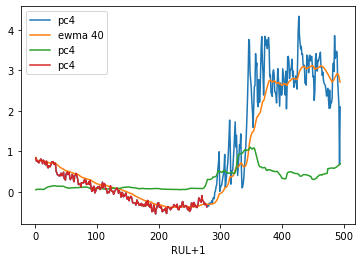

In [18]:
trajectory = 24

ax=pp.axes()
sensorTrace = train_dataPD.loc[trajectory,'pc4']
sensorTrace.plot(ax=ax)
ewma_span = 40
sensorTrace.ewm(span=ewma_span,ignore_na=True).mean().plot(ax=ax,label=('ewma ' + str(ewma_span)))

###### parameters for RMSdev the mask #######
window_size = 20
rmsdev_thrshld = 0.3
movRMS  =window_rmsdev(sensorTrace,window_size)
movRMS.plot()
#pp.plot(sensorTrace.index,movRMS,'ro')
ax.grid(b=True,which='both')
sensorTrace[movRMS<rmsdev_thrshld].plot()

ax.legend();



I will use only red-colored part of the trajectory in further analysis.

# classify the test data set


## classification based on exponential decay model fit:
* HPC degradation fault mode has PC1 moving upwards, but PC2 is moving downwards
* Fan degradation mode has both trends moving downwards

Therefore the signs of an amplitudes of the exponential fit of PC1 and PC2 will be a good classification parameter.

In [19]:
# Function to calculate the exponential with constants a and b
def linear(x, k, y):
    return (k*(x)  + y)
def exponential(x, A, k, y):
    return (A*np.exp(-k*(x))  + y)

class model:
    def __init__(self,dataPD, progSig,maskSignal,ufunc,p0,bounds,base_span,pcolumns, 
               window_size=20,rmsdev_thrshld=0.3,minMaskLen = 20):
        self.dataPD = dataPD
        self.progSig = progSig
        self.maskSignal=maskSignal
        self.ufunc = ufunc
        self.p0 = p0
        self.bounds = bounds
        self.base_span = base_span
        self.fit_expDF = pd.DataFrame(index=dataPD.index.get_level_values(level=0).unique(),
                             columns=pcolumns,dtype=np.float)
        self.window_size = window_size
        self.minMaskLen = minMaskLen
        self.rmsdev_thrshld = rmsdev_thrshld
        return
    def window_rmsdev(self,intervalS, halfwindow):
        """ performs the moving-window smoothing of a signal using RMS """
        interval = intervalS.values
        rms_signalS = pd.Series(index=intervalS.index, name=intervalS.name,dtype=np.float64)
        n = len(interval)
        rms_signal = np.zeros(n)
        for i in range(n):
            small_index = max(0, i - halfwindow)  # intended to avoid boundary effect
            big_index = min(n, i +  halfwindow)    # intended to avoid boundary effect
            window_samples = interval[small_index:big_index]
            x=np.mean(window_samples)
            # here is the RMS of the window, being attributed to rms_signal 'i'th sample:
            rms_signal[i] = np.sqrt(sum([(s-x)**2 for s in window_samples])/len(window_samples))
        rms_signalS.iloc[:] = rms_signal
        return rms_signalS

    def fit(self):
        for data_idx in self.fit_expDF.index: 
            # get mask
            movRMS  =self.window_rmsdev(self.dataPD.loc[data_idx,self.maskSignal],self.window_size)
            maskIdxs =   movRMS[movRMS < self.rmsdev_thrshld].index
            if len(maskIdxs)<minMaskLen: # do not apply mask if there will be nothing left
                maskIdxs = movRMS.index
            pc_idx=0 # position index of the prognostic parameter in the progSig list
            pars_errsA= np.array([],dtype=np.float) # temporary array for storing the fitted parameters
            for pc in self.progSig:
                trace=self. dataPD.loc[data_idx,pc].loc[maskIdxs]
                base = trace.iloc[-self.base_span:].mean()
                X = trace.index.values
                y = trace.values.astype(np.float)

                # Fit the experimental data
                pars, cov = curve_fit(f=self.ufunc, xdata=X, ydata=y, p0=self.p0, bounds=self.bounds)
                perr = np.sqrt(np.diag(cov)) # standard deviation errors on the parameters
                pars_errs = np.hstack([pars,perr])
                #print('score: ',reg.score(X, y), )
                yy = self.ufunc(X, *pars)
                pars_errsA=np.hstack([pars_errsA,pars_errs])
                pc_idx+=1
            self.fit_expDF.loc[data_idx,:]= pars_errsA
        return self.fit_expDF
            



# classification of the test trajectories 


Using exponential fit to classify the test trajectories was unsucessfull because the fit did not converged in some cases. The exponential function is not enoug robust.

I will try the linear regression instead.

In [20]:
# data
dataPD=train_dataPD
maskSignal = 'pc4'
progSig = ['pc1','pc2'] # prognostic signals    


# data structure for the fit result
pcolumns = [ 'k1', 'y1', 'k1std', 'y1std',
            'k2', 'y2','k2std', 'y2std'] # parameter columns

# initial fit parameters for the fitting function
base_span = 30
p0 = [ 0.02, -0.1]
bounds=(-np.inf,+np.inf)

# mask parameters
# mask parameters:
window_size = 20
rmsdev_thrshld = 0.3
minMaskLen = 20



expmodel = model(dataPD, progSig,maskSignal,linear,p0,bounds,base_span,pcolumns)

fit_expDF = expmodel.fit()


nrows=10
ncols=10
plotRows=1
#fig, ax = pp.subplots(figsize=(30,20),nrows=nrows*plotRows, ncols=ncols, sharex=True, sharey=True,)
#for traj_jdx in range (0,nrows,1):
#    for traj_idx in range(0,ncols,1): 

   

In [21]:
fms = ((np.sign(-fit_expDF['k2'].values)+1)//2).astype(np.int)
meta['lin_train_fault_modes'] = pd.Series(index=fit_expDF.index,
                                     name='fault mode',
                                     data=fms,
                                     dtype=np.int)

In [22]:
# data
dataPD=test_dataPD
maskSignal = 'pc4'
progSig = ['pc1','pc2'] # prognostic signals    


# data structure for the fit result
pcolumns = [ 'k1', 'y1', 'k1std', 'y1std',
            'k2', 'y2','k2std', 'y2std'] # parameter columns

# initial fit parameters for the fitting function
base_span = 30
p0 = [ 0.02, -0.1]
bounds=(-np.inf,+np.inf)

# mask parameters
# mask parameters:
window_size = 20
rmsdev_thrshld = 0.3
minMaskLen = 20



linmodel_test = model(dataPD, progSig,maskSignal,linear,p0,bounds,base_span,pcolumns)

fit_expDF = linmodel_test.fit()


nrows=10
ncols=10
plotRows=1
#fig, ax = pp.subplots(figsize=(30,20),nrows=nrows*plotRows, ncols=ncols, sharex=True, sharey=True,)
#for traj_jdx in range (0,nrows,1):
#    for traj_idx in range(0,ncols,1): 

   

In [23]:
fit_expDF.head()

k1        y1     k1std     y1std        k2        y2     k2std  \
unit                                                                         
1    -0.019217  1.265873  0.000622  0.083911  0.003329 -1.840319  0.000173   
2    -0.009332  0.175363  0.000476  0.034301 -0.014794  2.429908  0.000696   
3    -0.020016  3.457544  0.000771  0.104522  0.004219 -2.568634  0.000261   
4    -0.002514 -0.105555  0.000998  0.039596 -0.002844  1.646285  0.001245   
5    -0.023404 -3.554634  0.001428  0.114413  0.013199 -0.700101  0.000755   

         y2std  
unit            
1     0.023317  
2     0.050106  
3     0.035313  
4     0.049413  
5     0.060461

In [24]:
fms = ((np.sign(-fit_expDF['k2'].values)+1)//2).astype(np.int)
meta['lin_test_fault_modes'] = pd.Series(index=fit_expDF.index,
                                     name='fault mode',
                                     data=fms,
                                     dtype=np.int)

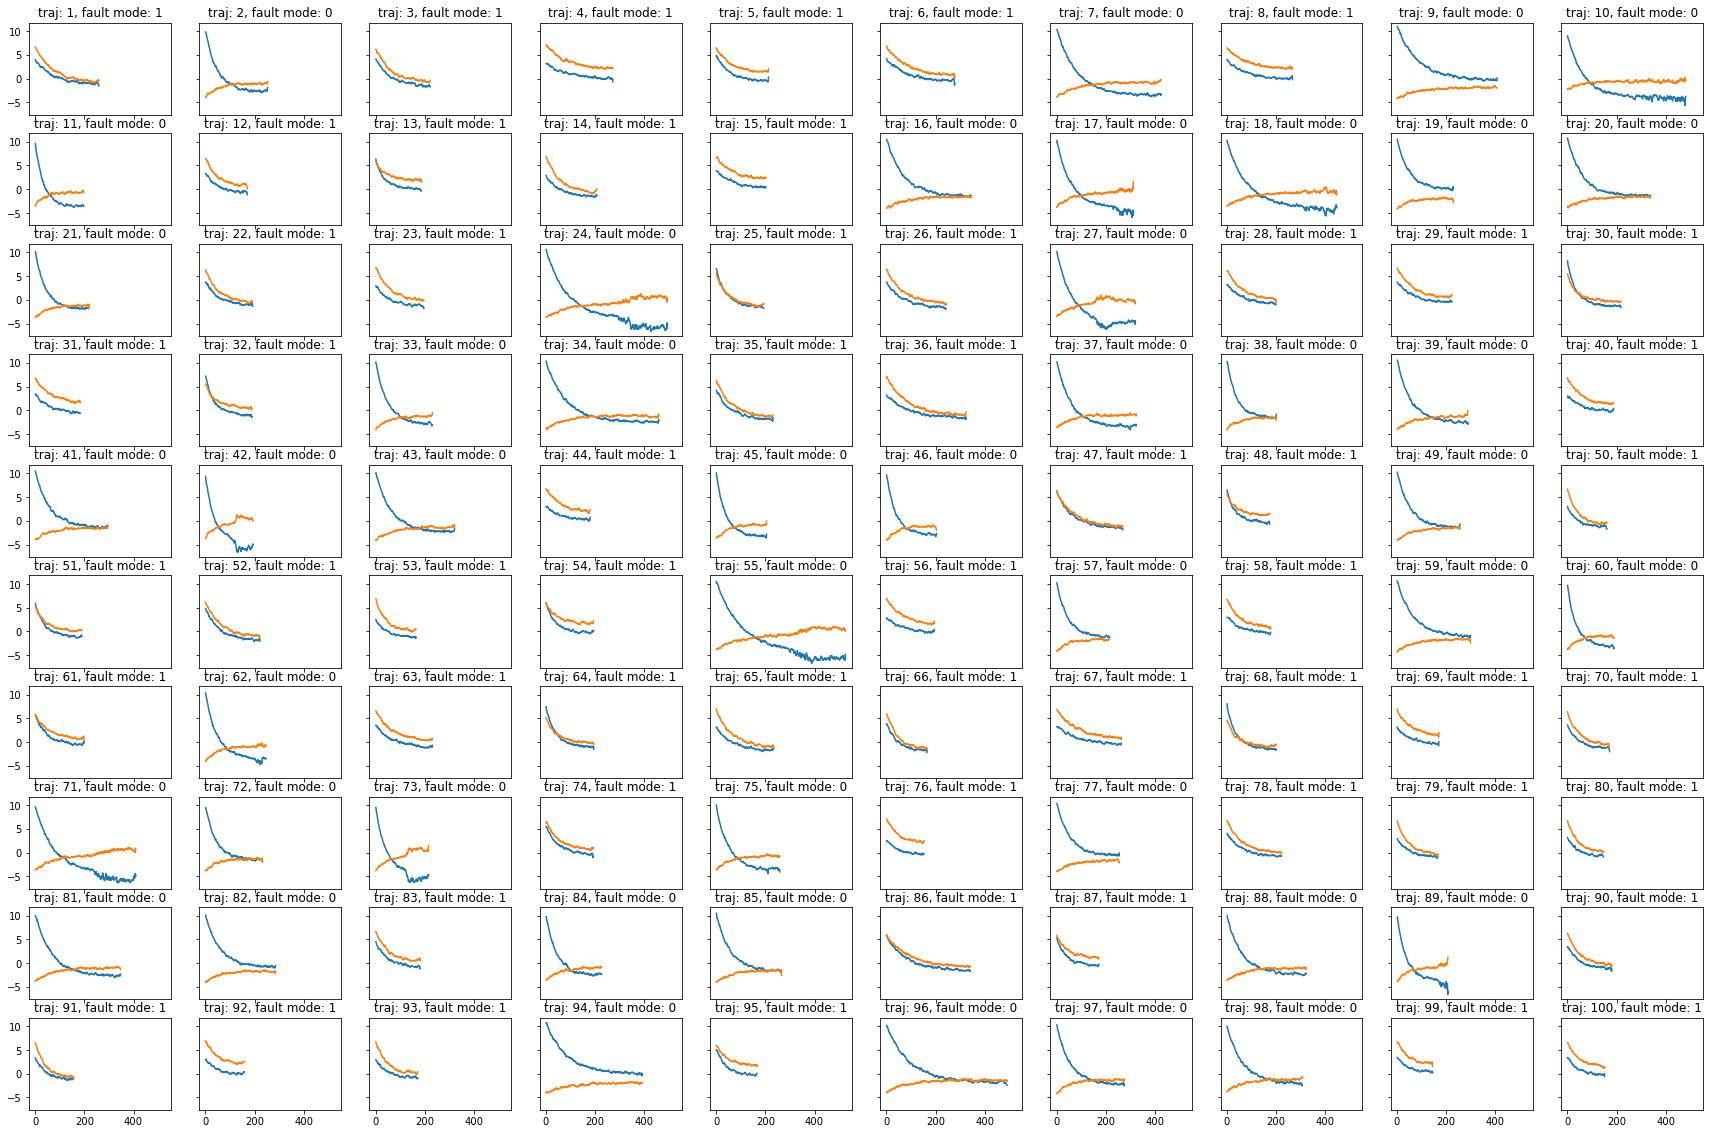

In [26]:
dataPD = train_dataPD
cats = meta['lin_train_fault_modes']
nrows=10
ncols=10
plotRows=1
fig, ax = pp.subplots(figsize=(30,20),nrows=nrows*plotRows, ncols=ncols, sharex=True, sharey=True,)
for traj_jdx in range (0,nrows,1):
    for traj_idx in range(0,ncols,1): 
        #operational parameters on every even row
        row=traj_jdx*plotRows
        col=traj_idx
        data_idx = ncols*traj_jdx+traj_idx+1
        #ax[row,col].plot(dataPD.loc[data_idx,'op1']*1000)
        #ax[row,col].plot(dataPD.loc[data_idx,'op2']*5000,alpha=0.4)
        #ax[row,col].axhline(y=0)
        # get mask
        for pc in progSig:
            trace=dataPD.loc[data_idx,pc]
            ax[row,col].plot(trace)

            
#            pc_idx+=1
        ax[row,col].set_title('traj: %d, fault mode: %d' % (data_idx,cats[data_idx]))

            

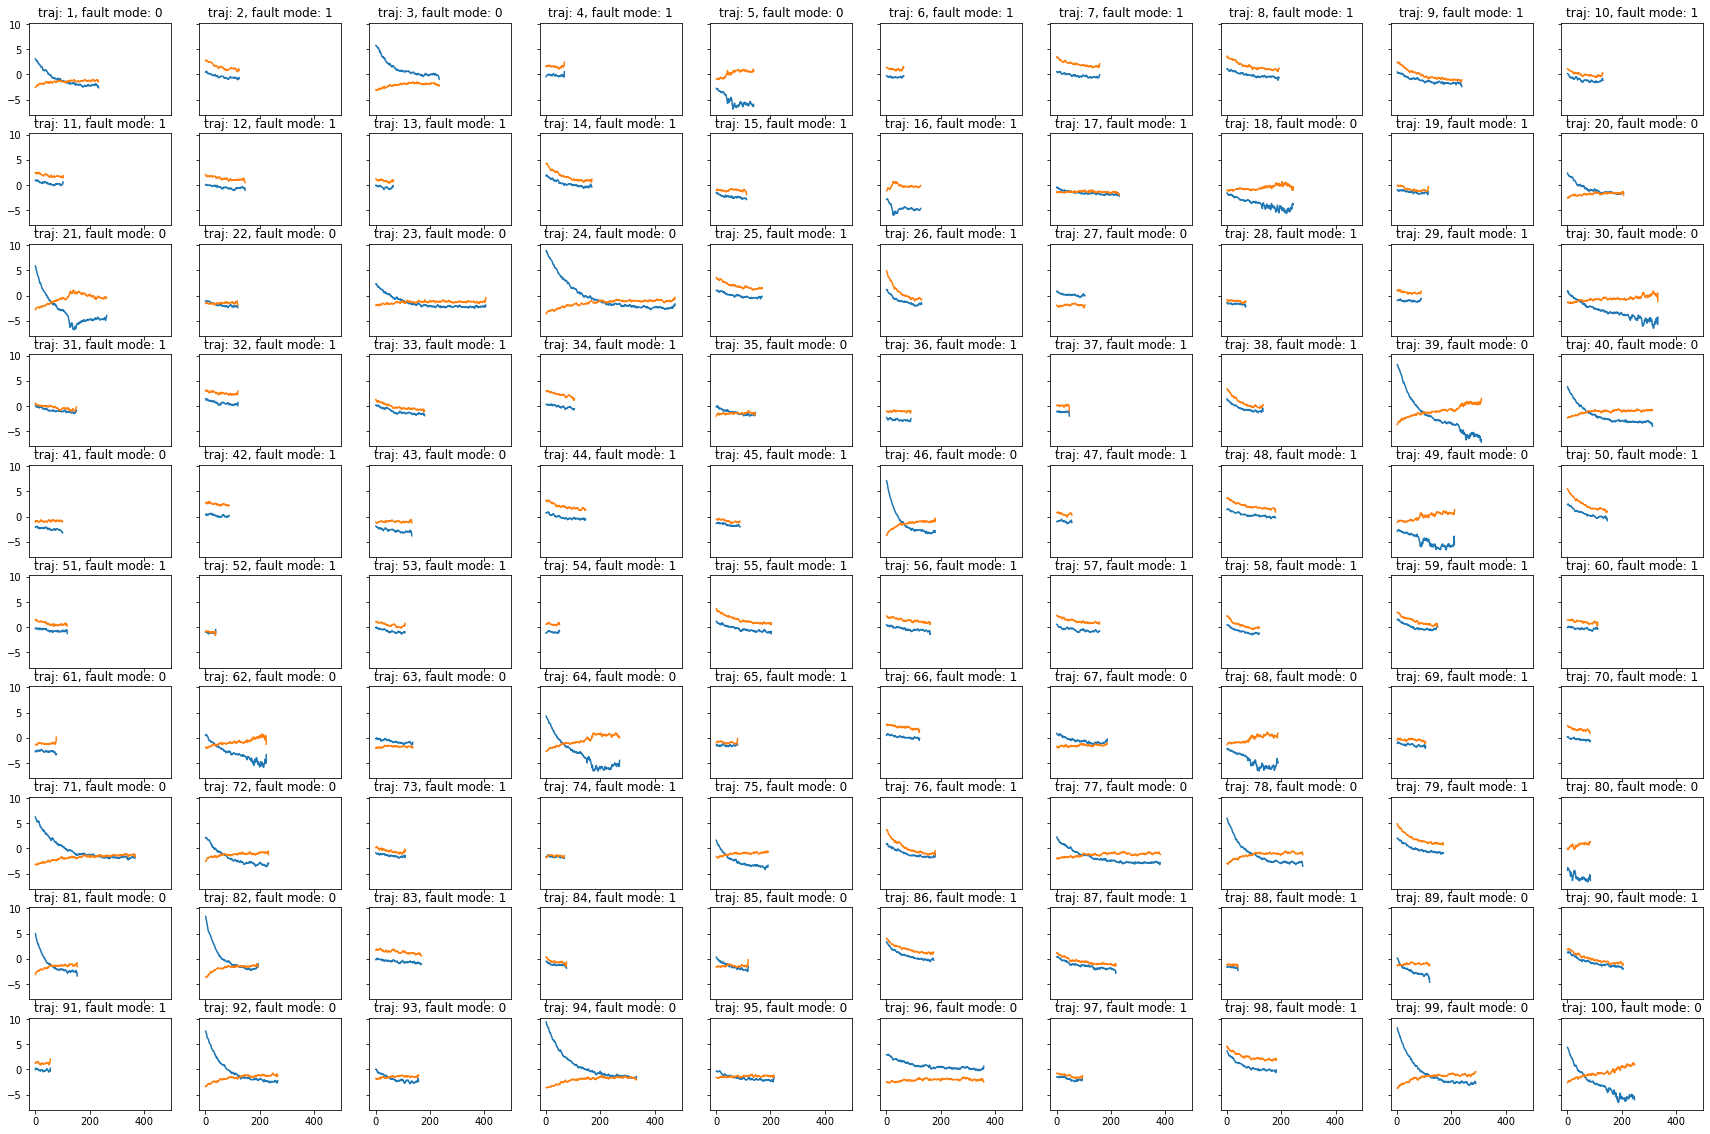

In [27]:
dataPD = test_dataPD
cats = meta['lin_test_fault_modes']
nrows=10
ncols=10
plotRows=1
fig, ax = pp.subplots(figsize=(30,20),nrows=nrows*plotRows, ncols=ncols, sharex=True, sharey=True,)
for traj_jdx in range (0,nrows,1):
    for traj_idx in range(0,ncols,1): 
        #operational parameters on every even row
        row=traj_jdx*plotRows
        col=traj_idx
        data_idx = ncols*traj_jdx+traj_idx+1
        #ax[row,col].plot(dataPD.loc[data_idx,'op1']*1000)
        #ax[row,col].plot(dataPD.loc[data_idx,'op2']*5000,alpha=0.4)
        #ax[row,col].axhline(y=0)
        # get mask
        for pc in progSig:
            trace=dataPD.loc[data_idx,pc]
            ax[row,col].plot(trace)

            
#            pc_idx+=1
        ax[row,col].set_title('traj: %d, fault mode: %d' % (data_idx,cats[data_idx]))

            

The fault modes are identified correctly in most cases also in the test data set. Although I am not sure about the result in trajectory 4.

# the RUL estimation using Recurrent Neural Network

In [28]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        shuffle=False,
                        callbacks=[early_stopping])
    return history

# create the window generator for RUL labels

### format the datasets to contain RUL as a last feature for training purposes

In [29]:

train_dataPD['RUL'] = train_dataPD.index.get_level_values(level='RUL+1') - 1

test_dataPD['RUL'] = test_dataPD.index.get_level_values(level='time') - 1
for trajectory in test_dataPD.index.get_level_values(level='unit').unique():
    base = test_dataPD.loc[trajectory,'RUL'].values
    test_dataPD.loc[trajectory,'RUL'] = base + RUL[meta['idx']].iloc[trajectory-1].values[0]
    pass

In [30]:
test_dataPD.head()

op1     op2      pc1      pc2        pc3       pc4  RUL
unit time                                                            
1    1     0.0021  0.0002  3.05901 -2.57413 -0.0753175  0.264034   44
     2     0.0038 -0.0005  2.93333 -2.51669 -0.0487394  0.266349   45
     3    -0.0002  0.0004  2.89334  -2.4549  -0.103544  0.333778   46
     4     0.0018       0  2.84947 -2.39237  -0.122808  0.373784   47
     5      0.003  0.0001   2.6896 -2.28033 -0.0717677  0.381208   48

In [31]:
train_dataPD.head()

op1     op2      pc1      pc2        pc3       pc4  RUL
unit RUL+1                                                            
1    1      0.0043 -0.0001  3.99856  6.66992  0.0018435  0.370615    0
     2     -0.0005  0.0001  3.82402  6.43589  0.0220312  0.263453    1
     3     -0.0032 -0.0002  3.65266  6.39414 -0.0288095  0.233016    2
     4      0.0019  0.0001  3.50451  6.26923 -0.0306323  0.317029    3
     5       0.005 -0.0004  3.46212  6.19971 -0.0543446  0.291636    4

In [32]:
# select exemplary trajectory from the train and test sets
# they should be of the same fault mode
#fm = 0 # fault mode 
test_fm_idxs = []
fault_modes = meta['lin_train_fault_modes'].unique()
fault_modes.sort()
for fm in fault_modes:

    test_fm_idxs.append( meta['lin_test_fault_modes']\
                        [meta['lin_test_fault_modes']==fm].index)
train_fm_idxs = []
for fm in fault_modes:
    train_fm_idxs.append( meta['lin_train_fault_modes']\
                         [meta['lin_train_fault_modes']==fm].index)



### the some data for initial tests

In [33]:
fm = 0 # fault mode 
val_idx = 0 # integer index of the trajectory within its fault mode category
test_idx = 4 
train_idx = 1
signals = ['pc1','pc2','pc3','pc4','RUL'] # adding the RUL as the last feature to faciliate the training and eval

test_traj_idx = test_fm_idxs[fm][test_idx]
test_df = test_dataPD.loc[test_traj_idx,signals]
val_traj_idx = test_fm_idxs[fm][val_idx]
val_df = test_dataPD.loc[val_traj_idx,signals]
train_traj_idx = train_fm_idxs[fm][train_idx]
train_df = train_dataPD.loc[train_traj_idx,signals]



C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


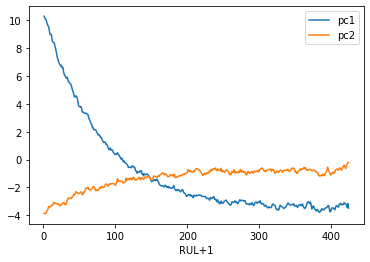

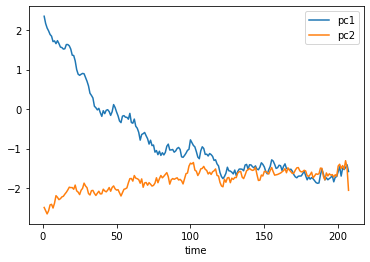

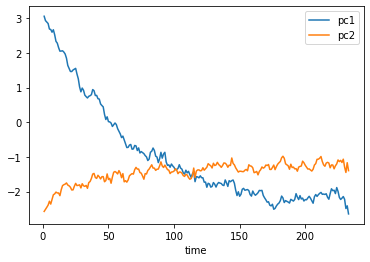

In [34]:
train_df.loc[:,'pc1':'pc2'].plot()
pp.axes()
test_df.loc[:,'pc1':'pc2'].plot()
pp.axes()
val_df.loc[:,'pc1':'pc2'].plot()

# compiling the data for the model input

## construct the data for feeding it in the model training

In [35]:
# separate the individual trajectories from train and test datasets into lists
# according to their fault mode
# fm ha meaing of the fault mode 

#    generate dictionaries by fault mode
test_by_fm = {} 
train_by_fm = {}
     
# filter properies
maskSignal='pc4'
window_size=20
rmsdev_thrshld=0.3
minMaskLen=38 # this is adjusted to the minimal trajectory lenght

signals =  test_dataPD.loc[:,'pc1':].columns


for fm in fault_modes:
    min_lenght = 1000
    for dataPD,data_fm_idxs,data_by_fm  in zip([test_dataPD,train_dataPD] ,
                                                [test_fm_idxs,train_fm_idxs],
                                                [test_by_fm,train_by_fm]):
        dataDict = {}
        for data_traj_idx in data_fm_idxs[fm]:
            data_df = dataPD.loc[data_traj_idx,:]
            #data_df = rms_mask(data_df, maskSignal,window_size=window_size,
            #                    rmsdev_thrshld=rmsdev_thrshld, minMaskLen=minMaskLen) 
            if len(data_df.index) <min_lenght:
                min_lenght = len(data_df.index) 
            data_df = data_df.loc[:,signals]
            dataDict[data_traj_idx] = pd.DataFrame(index=data_df.index,
                                                  columns=data_df.columns,
                                                  data=data_df.values,dtype=np.float32)
        data_by_fm[fm] = dataDict
        print ('fault mode: %d, minimal trajectory length: %d' % (fm,min_lenght))

fault mode: 0, minimal trajectory length: 78
fault mode: 0, minimal trajectory length: 78
fault mode: 1, minimal trajectory length: 38
fault mode: 1, minimal trajectory length: 38


## The window generator for trajectory time series

In [36]:
# generate windows to feed the model during training
class WindowGenerator_RUL():
    def __init__(self, input_width, label_width=1, shift=0,
               train_df=None, val_df=None, test_df=None,
               label_columns=None,
               batch_size=32,drop_remainder=True):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        # Work out prognostic features:
        self.prognostic_columns = []
        if label_columns is not None:
            for col_name in train_df.columns:
                if col_name not in label_columns: # use only columns that are NOT label as input
                    self.prognostic_columns.append(col_name)
                else:
                    pass
        else: 
            self.prognostic_columns = train_df.columns # if no label_columns are given use all columns in input
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        self.drop_remainder = drop_remainder

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        #self.label_start = self.total_window_size - self.label_width
        self.label_start = 0 # use only one label, that is in the first index
        self.labels_slice = slice(self.label_start, self.label_width)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.prognostic_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    def plot(self, model=None, plot_col='RUL', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} ')
            
            label_col_index = -1

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('time')
    def plot_RUL(self, model=None, plot_col='RUL'):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        #max_n = min(max_subplots, len(inputs))
        #plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} ')

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        plt.scatter(range(len(inputs)), labels[:, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(range(len(inputs)), predictions[:, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        
        plt.legend()

        plt.xlabel('sample')
    def plot_RUL_RNN(self, model=None, plot_col='RUL'):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        #max_n = min(max_subplots, len(inputs))
        #plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col}')

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        plt.scatter(range(len(inputs)), labels[:, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(range(len(inputs)), predictions[ :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        
        plt.legend()

        plt.xlabel('sample')
    def sequences_from_indices(self,array, indices_ds, start_index, end_index):
      dataset = dataset_ops.Dataset.from_tensors(array[start_index : end_index])
      dataset = dataset_ops.Dataset.zip((dataset.repeat(), indices_ds)).map(
          lambda steps, inds: array_ops.gather(steps, inds),  # pylint: disable=unnecessary-lambda
          num_parallel_calls=dataset_ops.AUTOTUNE)
      return dataset
    #@keras_export('keras.preprocessing.timeseries_dataset_from_array', v1=[])
    def timeseries_dataset_from_array(self,
        data,
        targets,
        sequence_length,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=128,
        shuffle=False,
        seed=None,
        start_index=None,
        end_index=None):
      """Creates a dataset of sliding windows over a timeseries provided as array.

      This function takes in a sequence of data-points gathered at
      equal intervals, along with time series parameters such as
      length of the sequences/windows, spacing between two sequence/windows, etc.,
      to produce batches of timeseries inputs and targets.

      Arguments:
        data: Numpy array or eager tensor
          containing consecutive data points (timesteps).
          Axis 0 is expected to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
          It should have same length as `data`. `targets[i]` should be the target
          corresponding to the window that starts at index `i`
          (see example 2 below).
          Pass None if you don't have target data (in this case the dataset will
          only yield the input data).
        sequence_length: Length of the output sequences (in number of timesteps).
        sequence_stride: Period between successive output sequences.
          For stride `s`, output samples would
          start at index `data[i]`, `data[i + s]`, `data[i + 2 * s]`, etc.
        sampling_rate: Period between successive individual timesteps
          within sequences. For rate `r`, timesteps
          `data[i], data[i + r], ... data[i + sequence_length]`
          are used for create a sample sequence.
        batch_size: Number of timeseries samples in each batch
          (except maybe the last one).
        shuffle: Whether to shuffle output samples,
          or instead draw them in chronological order.
        seed: Optional int; random seed for shuffling.
        start_index: Optional int; data points earlier (exclusive)
          than `start_index` will not be used
          in the output sequences. This is useful to reserve part of the
          data for test or validation.
        end_index: Optional int; data points later (exclusive) than `end_index`
          will not be used in the output sequences.
          This is useful to reserve part of the data for test or validation.

      Returns:
        A tf.data.Dataset instance. If `targets` was passed, the dataset yields
        tuple `(batch_of_sequences, batch_of_targets)`. If not, the dataset yields
        only `batch_of_sequences`.

      Example 1:
        Consider indices `[0, 1, ... 99]`.
        With `sequence_length=10,  sampling_rate=2, sequence_stride=3`,
        `shuffle=False`, the dataset will yield batches of sequences
        composed of the following indices:

      ```
      First sequence:  [0  2  4  6  8 10 12 14 16 18]
      Second sequence: [3  5  7  9 11 13 15 17 19 21]
      Third sequence:  [6  8 10 12 14 16 18 20 22 24]
      ...
      Last sequence:   [78 80 82 84 86 88 90 92 94 96]
      ```

      In this case the last 3 data points are discarded since no full sequence
      can be generated to include them (the next sequence would have started
      at index 81, and thus its last step would have gone over 99).

      Example 2: temporal regression. Consider an array `data` of scalar
      values, of shape `(steps,)`. To generate a dataset that uses the past 10
      timesteps to predict the next timestep, you would use:

      ```python
      input_data = data[:-10]
      targets = data[10:]
      dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          input_data, targets, sequence_length=10)
      for batch in dataset:
        inputs, targets = batch
        assert np.array_equal(inputs[0], data[:10])  # First sequence: steps [0-9]
        assert np.array_equal(targets[0], data[10])  # Corresponding target: step 10
        break
      ```
      """
      # Validate the shape of data and targets
      if targets is not None and len(targets) != len(data):
        raise ValueError('Expected data and targets to have the same number of '
                         'time steps (axis 0) but got '
                         'shape(data) = %s; shape(targets) = %s.' %
                         (data.shape, targets.shape))
      if start_index and (start_index < 0 or start_index >= len(data)):
        raise ValueError('start_index must be higher than 0 and lower than the '
                         'length of the data. Got: start_index=%s '
                         'for data of length %s.' % (start_index, len(data)))
      if end_index:
        if start_index and end_index <= start_index:
          raise ValueError('end_index must be higher than start_index. Got: '
                           'start_index=%s, end_index=%s.' %
                           (start_index, end_index))
        if end_index >= len(data):
          raise ValueError('end_index must be lower than the length of the data. '
                           'Got: end_index=%s' % (end_index,))
        if end_index <= 0:
          raise ValueError('end_index must be higher than 0. '
                           'Got: end_index=%s' % (end_index,))


      # Validate strides
      if sampling_rate <= 0 or sampling_rate >= len(data):
        raise ValueError(
            'sampling_rate must be higher than 0 and lower than '
            'the length of the data. Got: '
            'sampling_rate=%s for data of length %s.' % (sampling_rate, len(data)))
      if sequence_stride <= 0 or sequence_stride >= len(data):
        raise ValueError(
            'sequence_stride must be higher than 0 and lower than '
            'the length of the data. Got: sequence_stride=%s '
            'for data of length %s.' % (sequence_stride, len(data)))


      if start_index is None:
        start_index = 0
      if end_index is None:
        end_index = len(data)


      # Determine the lowest dtype to store start positions (to lower memory usage).
      num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
      if num_seqs < 2147483647:
        index_dtype = 'int32'
      else:
        index_dtype = 'int64'


      # Generate start positions
      start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
      if shuffle:
        if seed is None:
          seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(start_positions)


      sequence_length = math_ops.cast(sequence_length, dtype=index_dtype)
      sampling_rate = math_ops.cast(sampling_rate, dtype=index_dtype)


      positions_ds = dataset_ops.Dataset.from_tensors(start_positions).repeat()


      # For each initial window position, generates indices of the window elements
      indices = dataset_ops.Dataset.zip(
          (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
              lambda i, positions: math_ops.range(  # pylint: disable=g-long-lambda
                  positions[i],
                  positions[i] + sequence_length * sampling_rate,
                  sampling_rate),
              num_parallel_calls=dataset_ops.AUTOTUNE)


      dataset = self.sequences_from_indices(data, indices, start_index, end_index)
      if targets is not None:
        indices = dataset_ops.Dataset.zip(
            (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                lambda i, positions: positions[i],
                num_parallel_calls=dataset_ops.AUTOTUNE)
        target_ds = self.sequences_from_indices(
            targets, indices, start_index, end_index)
        dataset = dataset_ops.Dataset.zip((dataset, target_ds))
      if shuffle:
        # Shuffle locally at each iteration
        dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
      dataset = dataset.batch(batch_size,drop_remainder=self.drop_remainder)
      return dataset # timeseries_dataset_from_array
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        #ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        ds = self.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=False,
          batch_size=self.batch_size,
          )
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result



# Apply the WindowsGenerator class 

In [37]:
wide_window = WindowGenerator_RUL(
    input_width=30, # this is the minimal length of a trajectory
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['RUL',],batch_size=7) # we will use single sample batches, due to short niminal trajectory length

wide_window

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [0]
Label column name(s): ['RUL']

In [38]:
single_step_window = WindowGenerator_RUL(
    input_width=1, 
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['RUL',])

## let's look at the generated windows


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot i

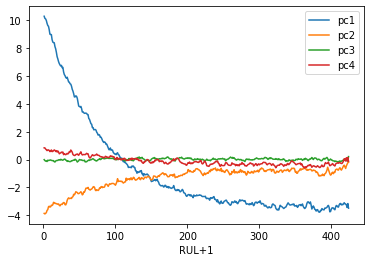

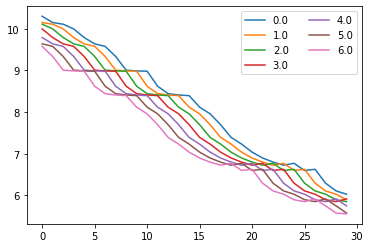

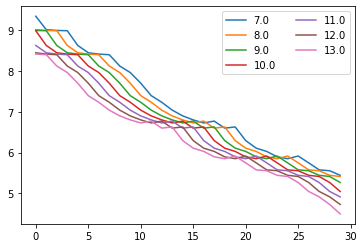

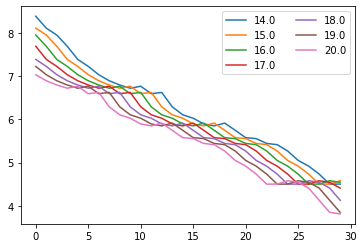

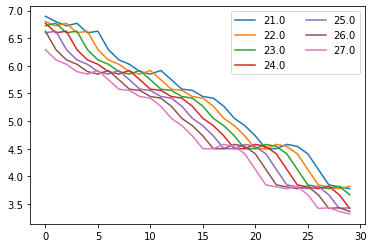

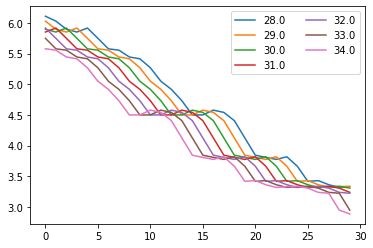

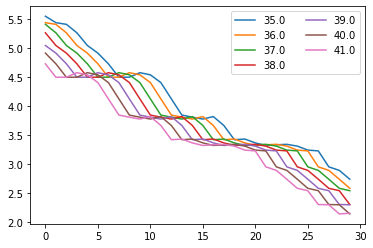

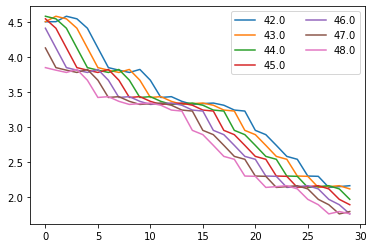

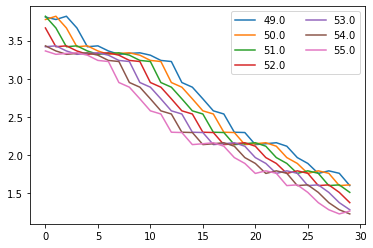

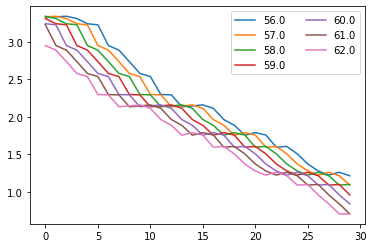

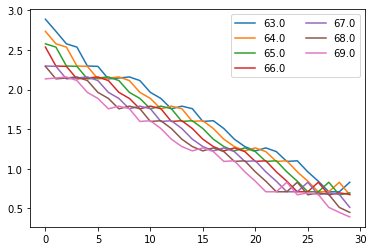

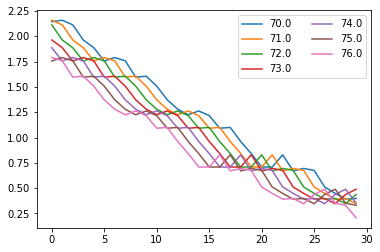

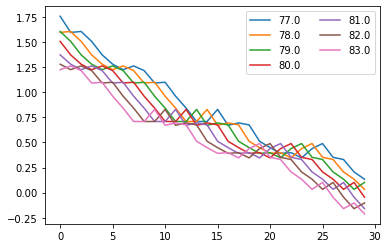

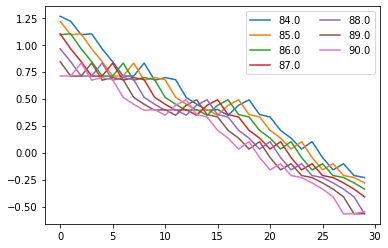

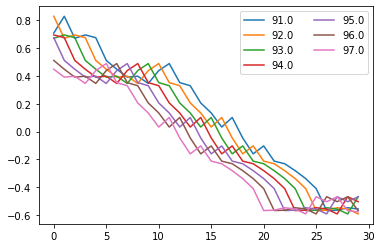

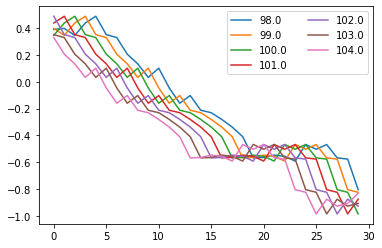

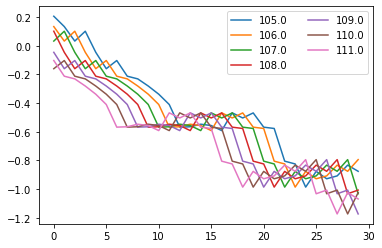

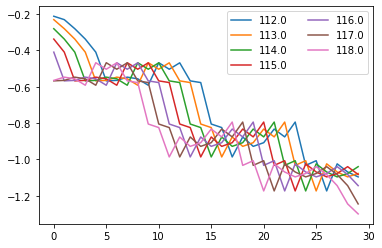

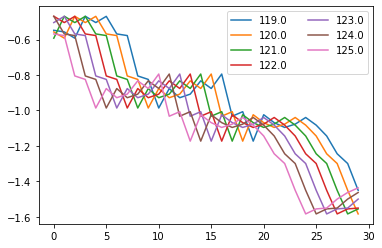

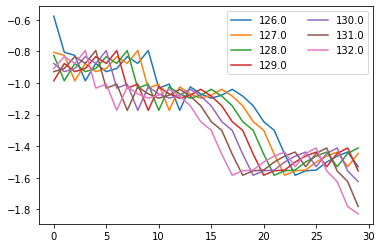

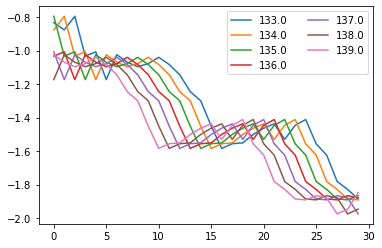

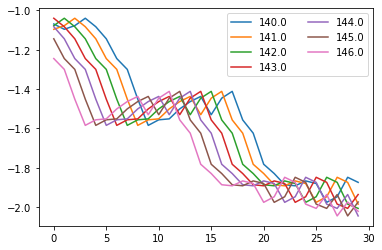

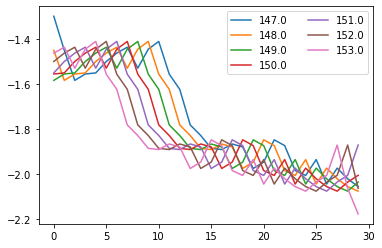

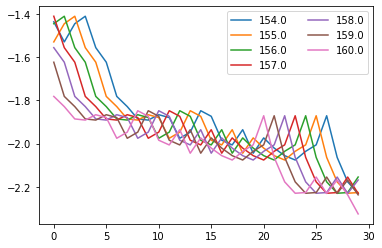

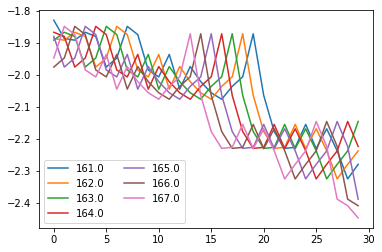

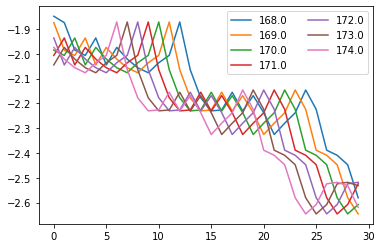

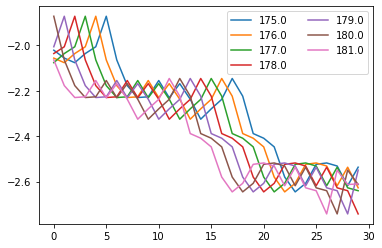

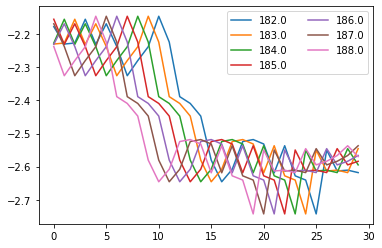

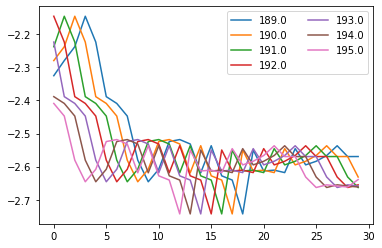

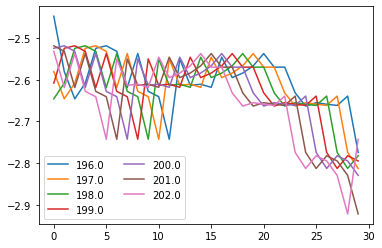

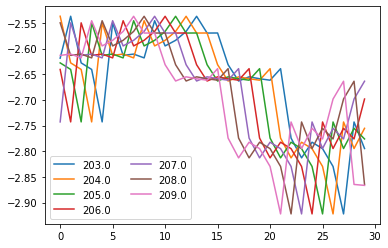

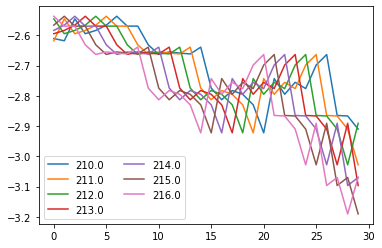

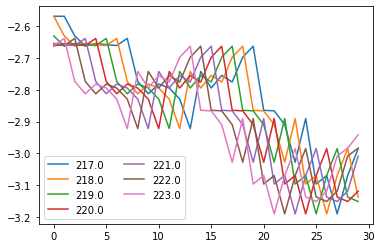

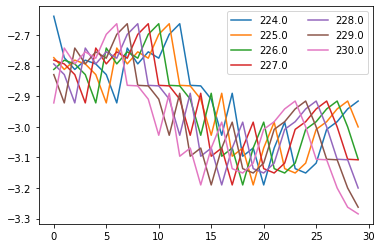

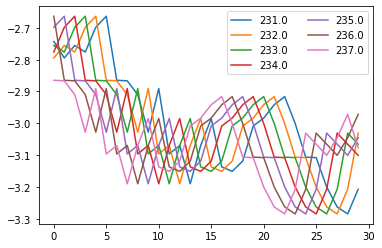

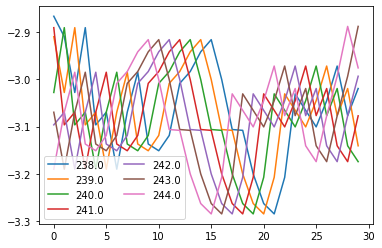

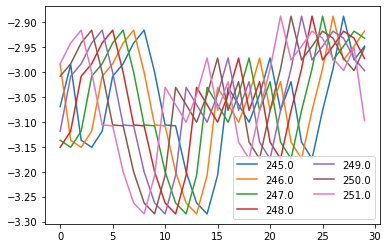

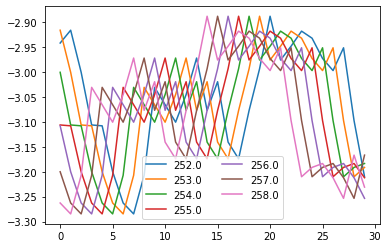

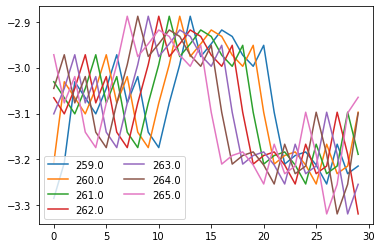

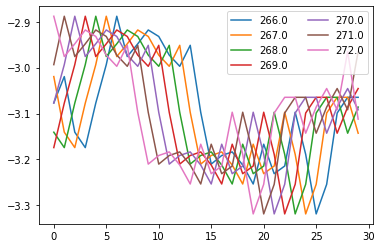

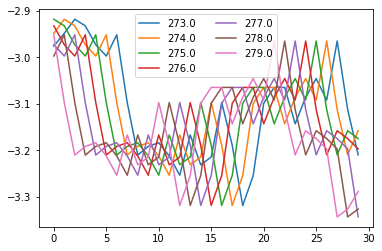

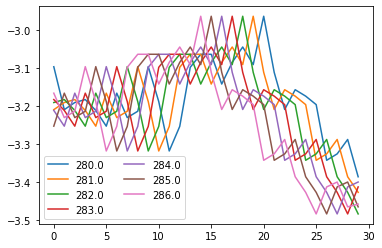

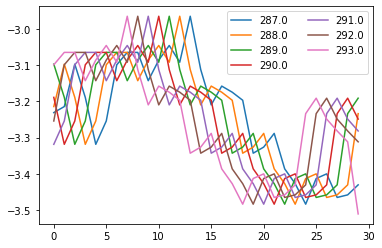

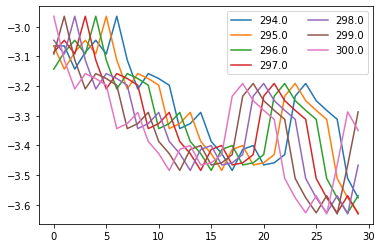

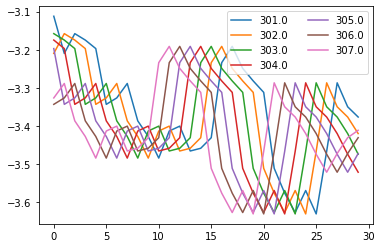

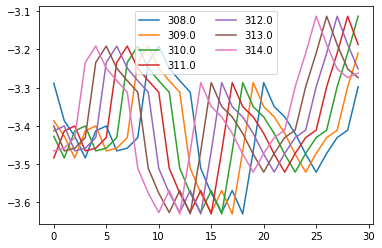

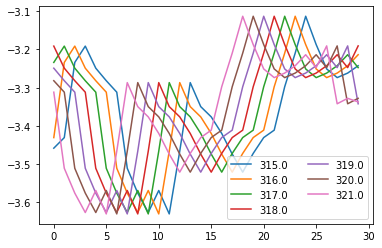

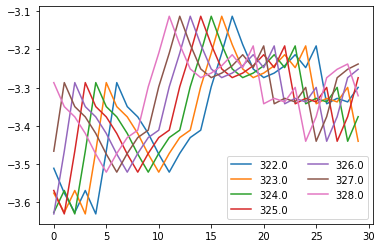

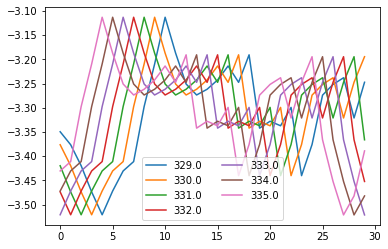

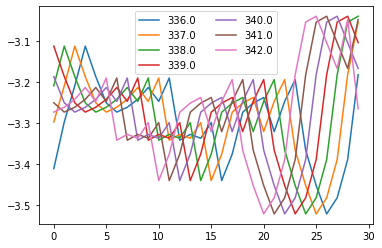

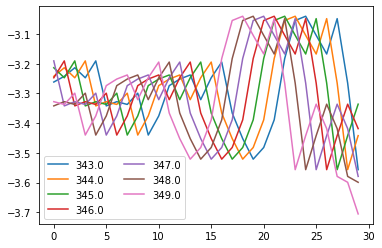

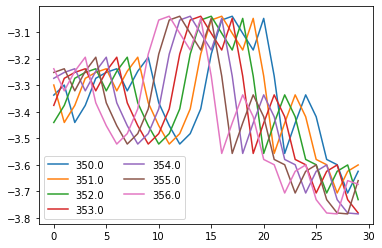

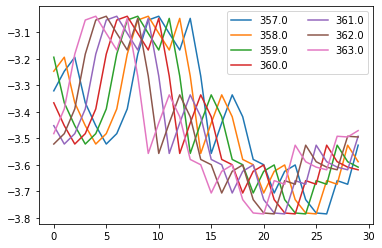

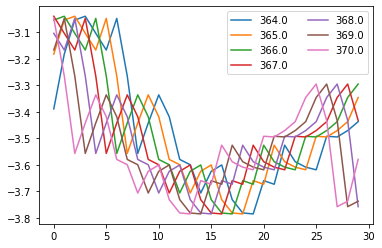

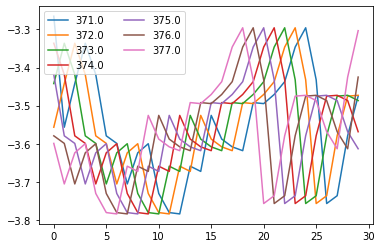

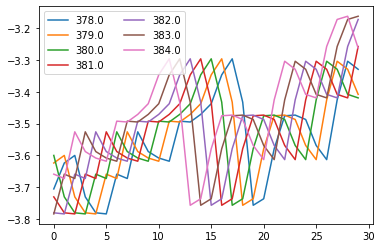

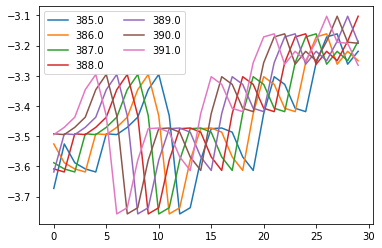

In [39]:
train_traj = wide_window.train.as_numpy_iterator()
wide_window.train_df.loc[:,:'pc4'].plot()
for inputs,labels in train_traj:
    fig=pp.figure()
    ax=pp.axes()
    for i in range(inputs.shape[0]):
        ax.plot(inputs[i,:,0],label=labels[i,0,0])
    ax.legend(ncol=2)


## The linear transformation model

In [40]:
def plotting(history):
    plt.plot(history.history['loss'], color = "red")
    plt.plot(history.history['val_loss'], color = "blue")
    red_patch = mpl.patches.Patch(color='red', label='Training')
    blue_patch = mpl.patches.Patch(color='blue', label='Test')
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')
    plt.show()


val_performance = {}
performance = {}

# the Long-Short Time Model

29/29 [==============================] - 0s 2ms/step - loss: 16362.2218 - mean_absolute_error: 113.7049


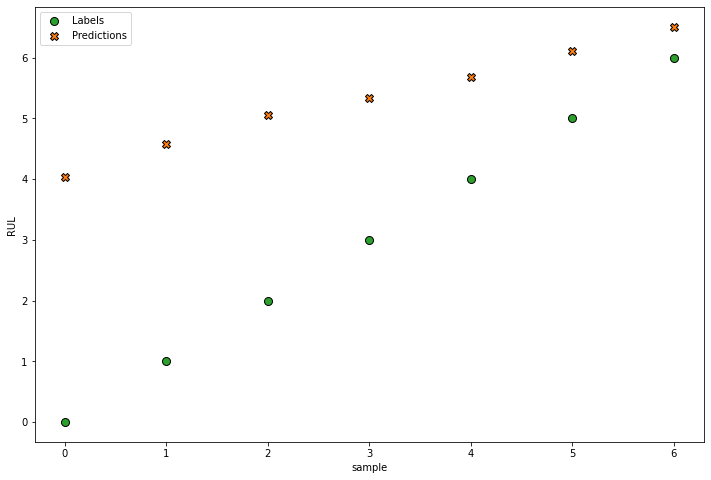

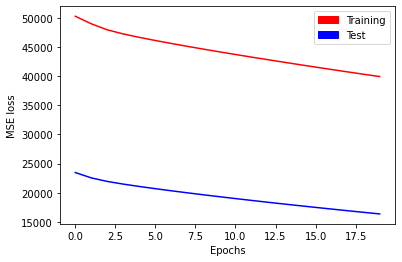

In [41]:
n_units=25
window_width=30
batch_size = 7

wide_window = WindowGenerator_RUL(
    input_width=window_width, 
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['RUL',],batch_size=batch_size)



lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(n_units, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

model_id = ('LSTM%dwin%d' % (n_units,window_width))
IPython.display.clear_output()
val_performance[model_id] = lstm_model.evaluate(wide_window.val)
performance[model_id] = lstm_model.evaluate(wide_window.test, verbose=0)

wide_window.plot_RUL_RNN(lstm_model)
fig=pp.figure()
plotting(history)

# The statefull LSTM model


29/29 [==============================] - 0s 2ms/step - loss: 16148.5395 - mean_absolute_error: 112.7606


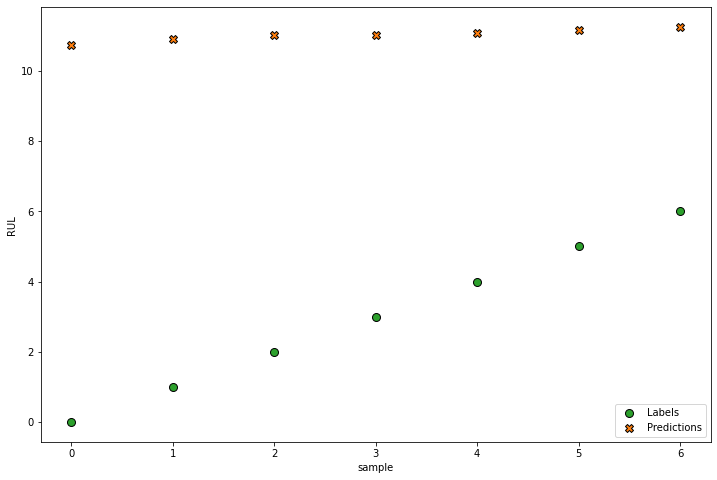

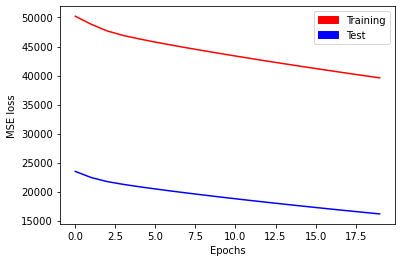

In [42]:
n_units=25
#window_width=30
dim_out=1
dim_in = 4
#batch_size = 7

wide_window = WindowGenerator_RUL(
    input_width=window_width, 
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['RUL',],batch_size=batch_size)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(batch_input_shape=(batch_size, None, dim_in),
               return_sequences=False, units=n_units, stateful=True))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(activation='linear', units=dim_out)))
model.add(tf.keras.layers.Dense(activation='linear', units=dim_out))
model.compile(loss = 'mse', optimizer = 'rmsprop')
    

history = compile_and_fit(model, wide_window)

model_id = ('sfLSTM%dwin%d' % (n_units,window_width))
IPython.display.clear_output()
val_performance[model_id] = model.evaluate(wide_window.val)
performance[model_id] = model.evaluate(wide_window.test, verbose=0)

wide_window.plot_RUL_RNN(model)
fig=pp.figure()
plotting(history)

## Try the GRU model

29/29 [==============================] - 0s 2ms/step - loss: 16544.7425 - mean_absolute_error: 114.5045


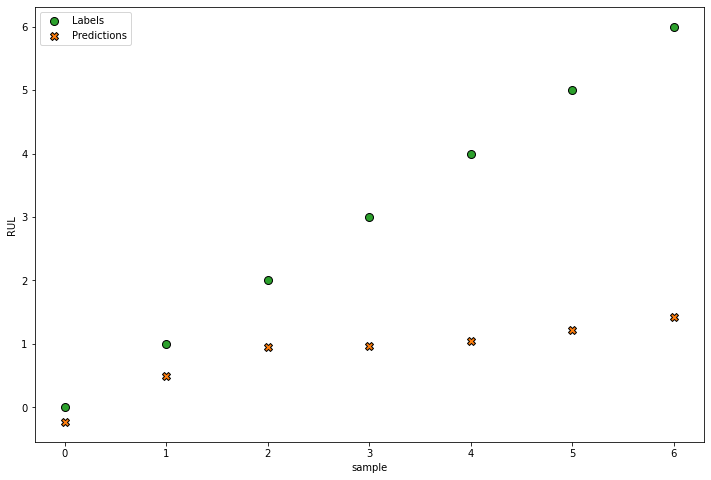

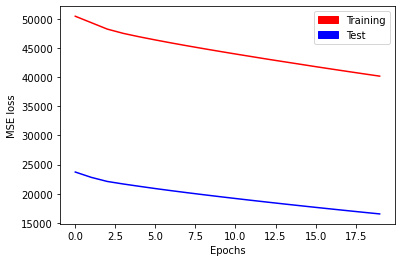

In [43]:
n_units=25
#window_width=30
#batch_size=7

model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(n_units, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
history = compile_and_fit(model, wide_window)

wide_window = WindowGenerator_RUL(
    input_width=window_width, 
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['RUL',],batch_size=batch_size)


model_id = ('GRU%dwin%d' % (n_units,window_width))
IPython.display.clear_output()
val_performance[model_id] = model.evaluate(wide_window.val)
performance[model_id] = model.evaluate(wide_window.test, verbose=0)
wide_window.plot_RUL_RNN(model)
fig=pp.figure()
plotting(history)

## compare the models fitted on single trajectory

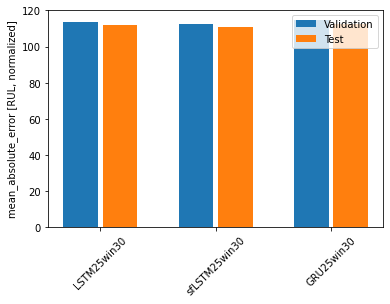

In [44]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [RUL, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


The models are giving quite the same results. There is large difference iin teh test results. We will feed the GRU model it with more data.

12/12 [==============================] - 0s 2ms/step - loss: 211.7701 - mean_absolute_error: 12.5073


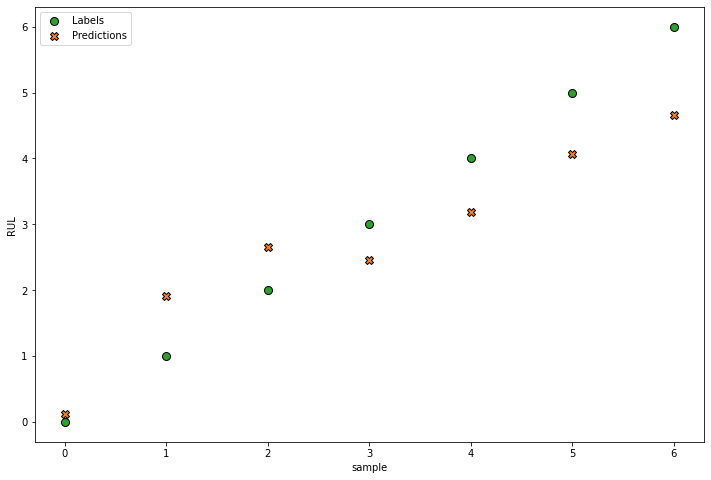

In [45]:
fm=0 # fault mode
n_units=25
#window_width=19
#batch_size=1

rnn_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(n_units, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

train_keys_dict = {i : trajectory for i, trajectory in enumerate(list(train_by_fm[fm].keys()))}

while True:
    train_keys = list(train_keys_dict.keys())
    remaining = len(train_keys)
    if len(train_keys)==0:
        break
    random_trajectory_key = random.choice(train_keys)
    select_train_trajectory_idx = train_keys_dict.pop(random_trajectory_key)
    train_df = train_by_fm[fm][select_train_trajectory_idx] # use each training dataset only once   
    test_trajectory_idx = random.choice(list(test_by_fm[fm].keys()))
    val_trajectory_idx = random.choice(list(test_by_fm[fm].keys()))
    print ('training on trajectory: %d, remaining trajs: %d ' % \
           (select_train_trajectory_idx,len(train_keys)))
    
    wide_window = WindowGenerator_RUL(
        input_width=window_width, 
        train_df=train_df, 
        val_df=test_by_fm[fm][val_trajectory_idx], 
        test_df=test_by_fm[fm][test_trajectory_idx],
        label_columns=['RUL',],batch_size=batch_size)

    history = compile_and_fit(rnn_model, wide_window)



model_id = ('GRU%dwin%d_fully' % (n_units,window_width))
IPython.display.clear_output()
val_performance[model_id] = rnn_model.evaluate(wide_window.val)
performance[model_id] = rnn_model.evaluate(wide_window.test, verbose=0)
wide_window.plot_RUL_RNN(rnn_model)

In [46]:
rnn_model.save('models/%s_time_series_FD003_trained_FultMode%d-batch%d.h5' % (model_id, fm,batch_size))

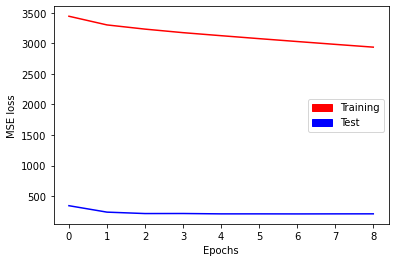

In [47]:
plotting(history)

#### use the model for prediciton

In [48]:
fm=0 # fault mode

# Compare the RUL estimation  the test dataset
# the predicted value of the RUL will be the one from the first line of the first batch.

def get_prediction (model,test_df,window_width,batch_size=32):
    test_window = WindowGenerator_RUL(
        input_width=window_width, 
        train_df=test_df, 
        val_df=test_df, 
        test_df=test_df,
        label_columns=['RUL',],batch_size=batch_size)
    data = test_window.val.as_numpy_iterator()
    data = data.next()
    trueRUL = test_df.iloc[0,:].loc['RUL']
    predictions = model.predict(data[0])
    RUL_est = predictions[0][0]
    return ( trueRUL, RUL_est)



In [49]:
fm=0

testsDict = test_by_fm[fm]
trueRULs = []
RUL_ests = []
indexes = []
for idx, test_df in testsDict.items():
    print ('idx%d-len%d'%(idx,len(test_df.index)), end=' ')
    trueRUL, RUL_est = get_prediction (rnn_model,test_df,window_width=window_width,batch_size=batch_size)
    trueRULs.append(trueRUL)
    RUL_ests.append(RUL_est)
    indexes.append(idx)



idx1-len233 idx3-len234 idx5-len138 idx18-len244 idx20-len207 idx21-len263 idx22-len119 idx23-len405 idx24-len475 idx27-len104 idx30-len333 idx35-len144 idx39-len310 idx40-len313 idx41-len101 idx43-len133 idx46-len180 idx49-len211 idx61-len78 idx62-len224 idx63-len137 idx64-len271 idx67-len186 idx68-len188 idx71-len367 idx72-len232 idx75-len191 idx77-len381 idx78-len279 idx80-len85 idx81-len155 idx82-len194 idx85-len118 idx89-len120 idx92-len266 idx93-len158 idx94-len333 idx95-len213 idx96-len358 idx99-len289 idx100-len247 

### test the trained model on the test dataset:

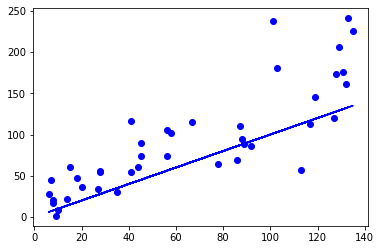

In [50]:
results = np.vstack([np.array(RUL_ests),np.array(trueRULs)]).T
columns = (model_id+('fm: %d' %fm),'ground_truth')
rnn_results_fm0 = pd.DataFrame(index=indexes,data=results,columns=columns)
#rnn_results_fm0.plot()

pp.plot(rnn_results_fm0.iloc[:,1].values,rnn_results_fm0.iloc[:,0].values,'bo')
pp.plot(rnn_results_fm0.iloc[:,1].values,rnn_results_fm0.iloc[:,1].values,'b-')

The estimations are quite well correlated with the ground truth values.

## try this model for the other fault mode

10/10 [==============================] - 0s 2ms/step - loss: 191.9547 - mean_absolute_error: 11.4105


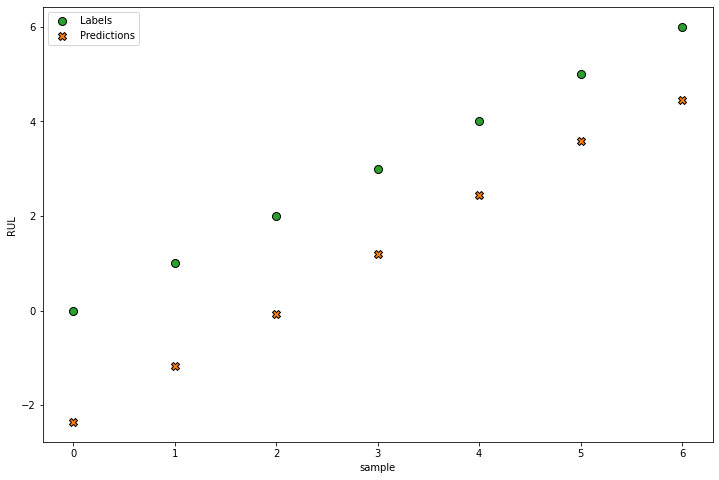

In [51]:
fm=1 # fault mode
#n_units=25
#window_width=30
#batch_size=7

rnn_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(n_units, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

train_keys_dict = {i : trajectory for i, trajectory in enumerate(list(train_by_fm[fm].keys()))}

while True:
    train_keys = list(train_keys_dict.keys())
    remaining = len(train_keys)
    if len(train_keys)==0:
        break
    random_trajectory_key = random.choice(train_keys)
    select_train_trajectory_idx = train_keys_dict.pop(random_trajectory_key)
    train_df = train_by_fm[fm][select_train_trajectory_idx] # use each training dataset only once   
    test_trajectory_idx = random.choice(list(test_by_fm[fm].keys()))
    val_trajectory_idx = random.choice(list(test_by_fm[fm].keys()))
    print ('training on trajectory: %d, remaining trajs: %d ' % \
           (select_train_trajectory_idx,len(train_keys)))
    
    wide_window = WindowGenerator_RUL(
        input_width=window_width, 
        train_df=train_df, 
        val_df=test_by_fm[fm][val_trajectory_idx], 
        test_df=test_by_fm[fm][test_trajectory_idx],
        label_columns=['RUL',],batch_size=batch_size)

    history = compile_and_fit(rnn_model, wide_window)



model_id = ('GRU%dwin%d_fully' % (n_units,window_width))
IPython.display.clear_output()
val_performance[model_id] = rnn_model.evaluate(wide_window.val)
performance[model_id] = rnn_model.evaluate(wide_window.test, verbose=0)
wide_window.plot_RUL_RNN(rnn_model)

In [52]:
rnn_model.save('models/%s_time_series_FD003_trained_FultMode%d-batch%d.h5' % (model_id, fm,batch_size))

### calculate the prediction for fault mode 1:

idx2-len124 idx4-len68 idx6-len64 idx7-len158 idx8-len192 idx9-len238 idx10-len131 idx11-len103 idx12-len146 idx13-len65 idx14-len169 idx15-len112 idx16-len126 idx17-len230 idx19-len115 idx25-len169 idx26-len130 idx28-len70 idx29-len89 idx31-len152 idx32-len120 idx33-len180 idx34-len105 idx36-len90 idx37-len47 idx38-len133 idx42-len87 idx44-len146 idx45-len88 idx47-len56 idx48-len179 idx50-len147 idx51-len118 idx52-len38 idx53-len108 idx54-len50 idx55-len203 idx56-len162 idx57-len158 idx58-len119 idx59-len149 idx60-len112 idx65-len79 idx66-len122 idx69-len105 idx70-len84 idx73-len109 idx74-len68 idx76-len180 idx79-len170 idx83-len168 idx84-len76 idx86-len174 idx87-len218 idx88-len41 idx90-len206 idx91-len56 idx97-len95 idx98-len182 

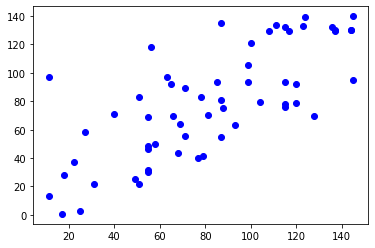

In [53]:
fm=1

testsDict = test_by_fm[fm]
trueRULs = []
RUL_ests = []
indexes = []
for idx, test_df in testsDict.items():
    print ('idx%d-len%d'%(idx,len(test_df.index)), end=' ')
    trueRUL, RUL_est = get_prediction (rnn_model,test_df,window_width=window_width,batch_size=batch_size)
    trueRULs.append(trueRUL)
    RUL_ests.append(RUL_est)
    indexes.append(idx)

results = np.vstack([np.array(RUL_ests),np.array(trueRULs)]).T
columns = (model_id+('fm: %d' %fm),'ground_truth')
rnn_results_fm1 = pd.DataFrame(index=indexes,data=results,columns=columns)
#rnn_results_fm0.plot()

pp.plot(rnn_results_fm1.iloc[:,1].values,rnn_results_fm1.iloc[:,0].values,'bo')


In [54]:
meta['GRU25_test_fit']= pd.DataFrame(index=testData[meta['idx']].index.get_level_values(level=0).unique(),
                                  columns=['RUL',],
                                  dtype=np.float)
meta['GRU25_test_fit_by_fault'] = []
for fit in [rnn_results_fm0,rnn_results_fm1]:
    meta['GRU25_test_fit_by_fault'].append(fit)
    meta['GRU25_test_fit'].loc[fit.index,'RUL'] = fit.iloc[:,0].values

# plot and save the fit results

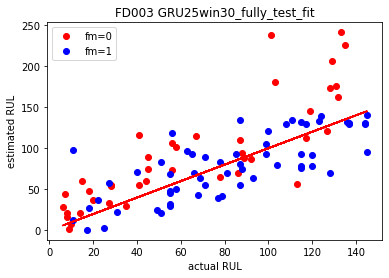

In [55]:
ax=pp.axes()
fm=0
pp.plot(RUL[meta['idx']].loc[meta['GRU25_test_fit_by_fault'][fm].index-1].values,
            meta['GRU25_test_fit_by_fault'][fm].iloc[:,0].values,
            'ro',label='fm=%d'%fm)
fm=1
pp.plot(RUL[meta['idx']].loc[meta['GRU25_test_fit_by_fault'][fm].index-1].values,
            meta['GRU25_test_fit_by_fault'][fm].iloc[:,0].values,
            'bo',label='fm=%d'%fm)
pp.legend()
pp.xlabel('actual RUL')
pp.ylabel('estimated RUL')
pp.title(meta['Data Set Name']+ (' %s_test_fit' % model_id))
#ax.set_ylim([0,300])
ax.plot(RUL[meta['idx']].values,RUL[meta['idx']].values,'r-')
pp.savefig('models/GRU25_test_fit_FD003.png')

In [56]:
meta['GRU25_test_fit'].to_csv('models/GRU25_test_fit_FD003.csv')

In [57]:
truths = RUL[meta['idx']].values
predicts = meta['GRU25_test_fit'].values
RMSE = np.sqrt(mean_squared_error(truths,predicts))
R2 = r2_score(truths,predicts)

print ('dataset: %s, model: %s, RMSE = %.1f cycles, Rsquared = %.3f' % (meta['Data Set Name'],model_id,RMSE,R2))

dataset: FD003, model: GRU25win30_fully, RMSE = 35.7 cycles, Rsquared = 0.827
